# **Avocado Retailing- Prescriptive Analysis**

In [1]:
!pip install pulp

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pulp import LpProblem, LpVariable, LpMinimize, lpSum, value

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Read the data
data_new_df = pd.read_excel('/content/Avocado_USDA_data_market.xlsx')
data_new_df.head()

,Date,Region,Class,Commodity,Variety,Organic,Environment,Unit,Number of Stores,Weighted Avg Price,Low Price,High Price,Supply Type
0,2023-01-06,NORTHEAST U.S.,FRUITS,AVOCADOS,HASS,NaN,NaN,each,971,1.11,0.75,1.67,Imported
1,2023-01-06,NORTHEAST U.S.,FRUITS,AVOCADOS,HASS,Y,NaN,each,351,1.80,1.67,2.50,Imported
2,2023-01-06,NORTHEAST U.S.,FRUITS,AVOCADOS,VARIOUS GREENSKIN VARIETIES,NaN,NaN,each,8,1.67,1.67,1.67,Imported
3,2023-01-06,SOUTHEAST U.S.,FRUITS,AVOCADOS,HASS,NaN,NaN,each,2183,0.98,0.50,1.67,Imported
4,2023-01-06,SOUTHEAST U.S.,FRUITS,AVOCADOS,HASS,Y,NaN,each,552,1.65,1.25,2.00,Imported


In [4]:
# Get the number of rows and columns
data_new_df.shape

(239, 13)

In [5]:
# Get the info of all the columns
data_new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239 entries, 0 to 238
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                239 non-null    datetime64[ns]
 1   Region              239 non-null    object        
 2   Class               239 non-null    object        
 3   Commodity           239 non-null    object        
 4   Variety             239 non-null    object        
 5   Organic             91 non-null     object        
 6   Environment         0 non-null      float64       
 7   Unit                239 non-null    object        
 8   Number of Stores    239 non-null    int64         
 9   Weighted Avg Price  239 non-null    float64       
 10  Low Price           239 non-null    float64       
 11  High Price          239 non-null    float64       
 12  Supply Type         239 non-null    object        
dtypes: datetime64[ns](1), float64(4), int64(1), object

In [6]:
# Data Cleaning Code
# Initial inspection of the data to identify cleaning needs
cleaned_data = data_new_df.copy()

# Convert 'Date' column to a consistent datetime format
cleaned_data['Date'] = pd.to_datetime(cleaned_data['Date'], errors='coerce')

# Standardize and fill missing values in 'Organic' column (replace NaN with "No")
cleaned_data['Organic'] = cleaned_data['Organic'].fillna('N')

# Drop columns with entirely missing values ('Environment' seems irrelevant here)
cleaned_data = cleaned_data.drop(columns=['Environment'])

# Normalize 'Unit' column values (ensure uniformity between "each" and "per pound")
# No transformation needed now, but identify unique values for validation
unit_values = cleaned_data['Unit'].unique()

# Display the cleaned dataset and unique values in the 'Unit' column for verification
cleaned_data.head(), unit_values

(        Date          Region   Class Commodity                      Variety  \
 0 2023-01-06  NORTHEAST U.S.  FRUITS  AVOCADOS                         HASS   
 1 2023-01-06  NORTHEAST U.S.  FRUITS  AVOCADOS                         HASS   
 2 2023-01-06  NORTHEAST U.S.  FRUITS  AVOCADOS  VARIOUS GREENSKIN VARIETIES   
 3 2023-01-06  SOUTHEAST U.S.  FRUITS  AVOCADOS                         HASS   
 4 2023-01-06  SOUTHEAST U.S.  FRUITS  AVOCADOS                         HASS   
 
   Organic  Unit  Number of Stores  Weighted Avg Price  Low Price  High Price  \
 0       N  each               971                1.11       0.75        1.67   
 1       Y  each               351                1.80       1.67        2.50   
 2       N  each                 8                1.67       1.67        1.67   
 3       N  each              2183                0.98       0.50        1.67   
 4       Y  each               552                1.65       1.25        2.00   
 
   Supply Type  
 0    Importe

In [7]:
cleaned_data.shape

(239, 12)

In [8]:
# Remove duplicate rows
cleaned_data = cleaned_data.drop_duplicates()

# Fill missing values in non-critical columns (e.g., 'Variety') with 'Unknown'
cleaned_data['Variety'] = cleaned_data['Variety'].fillna('Unknown')

# Ensure 'Weighted Avg Price' column has only positive values
cleaned_data = cleaned_data[cleaned_data['Weighted Avg Price'] > 0]

# Ensure 'Number of Stores' is valid (positive integers)
cleaned_data = cleaned_data[cleaned_data['Number of Stores'] > 0]

# Standardize 'Unit' values
cleaned_data['Unit'] = cleaned_data['Unit'].str.lower().str.strip()

# Verify data integrity post-cleaning
row_count, column_count = cleaned_data.shape
cleaned_data.info(), row_count, column_count

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239 entries, 0 to 238
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                239 non-null    datetime64[ns]
 1   Region              239 non-null    object        
 2   Class               239 non-null    object        
 3   Commodity           239 non-null    object        
 4   Variety             239 non-null    object        
 5   Organic             239 non-null    object        
 6   Unit                239 non-null    object        
 7   Number of Stores    239 non-null    int64         
 8   Weighted Avg Price  239 non-null    float64       
 9   Low Price           239 non-null    float64       
 10  High Price          239 non-null    float64       
 11  Supply Type         239 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(7)
memory usage: 22.5+ KB


(None, 239, 12)

In [9]:
# Remove rows with dates outside the expected range
cleaned_data = cleaned_data[
    (cleaned_data['Date'] >= '2015-01-01') & (cleaned_data['Date'] <= '2024-11-30')
]

In [10]:
# Detect and remove outliers using IQR
Q1 = cleaned_data[['Weighted Avg Price', 'Number of Stores']].quantile(0.25)
Q3 = cleaned_data[['Weighted Avg Price', 'Number of Stores']].quantile(0.75)
IQR = Q3 - Q1

cleaned_data = cleaned_data[
    ~((cleaned_data[['Weighted Avg Price', 'Number of Stores']] < (Q1 - 1.5 * IQR)) |
      (cleaned_data[['Weighted Avg Price', 'Number of Stores']] > (Q3 + 1.5 * IQR))).any(axis=1)
]

In [11]:
cleaned_data.shape

(235, 12)

In [12]:
# Group rare varieties into "Other"
variety_counts = cleaned_data['Variety'].value_counts()
rare_varieties = variety_counts[variety_counts < 10].index

cleaned_data['Variety'] = cleaned_data['Variety'].replace(rare_varieties, 'Other')

In [13]:
# Example transformation (if applicable)
cleaned_data.loc[cleaned_data['Unit'] == 'per pound', 'Weighted Avg Price'] *= 2

In [14]:
cleaned_data['Price Per Store'] = cleaned_data['Weighted Avg Price'] / cleaned_data['Number of Stores']

In [15]:
# Summarize categorical columns
cleaned_data.describe(include='object')

,Region,Class,Commodity,Variety,Organic,Unit,Supply Type
count,235,235,235,235,235,235,235
unique,3,1,1,2,2,2,2
top,SOUTHEAST U.S.,FRUITS,AVOCADOS,HASS,N,each,Imported
freq,83,235,235,196,144,226,204


## **EXPLORATORY DATA ANALYSIS**

In [16]:
# 1. General Overview
print("Summary Statistics for Numeric Columns:")
print(cleaned_data.describe())

print("\nDistribution of Categorical Columns:")
print(cleaned_data['Region'].value_counts())
print(cleaned_data['Variety'].value_counts())
print(cleaned_data['Supply Type'].value_counts())

Summary Statistics for Numeric Columns:
                                Date  Number of Stores  Weighted Avg Price  \
count                            235        235.000000          235.000000   
mean   2023-05-02 09:48:15.319149056        778.595745            1.475021   
min              2023-01-06 00:00:00          2.000000            0.590000   
25%              2023-02-27 12:00:00         79.000000            1.035000   
50%              2023-04-28 00:00:00        446.000000            1.350000   
75%              2023-07-07 00:00:00       1371.500000            1.880000   
max              2023-09-01 00:00:00       3111.000000            3.500000   
std                              NaN        840.896755            0.512189   

        Low Price  High Price  Price Per Store  
count  235.000000  235.000000       235.000000  
mean     1.092851    1.974085         0.041512  
min      0.250000    0.500000         0.000286  
25%      0.660000    1.670000         0.000836  
50%      0.9

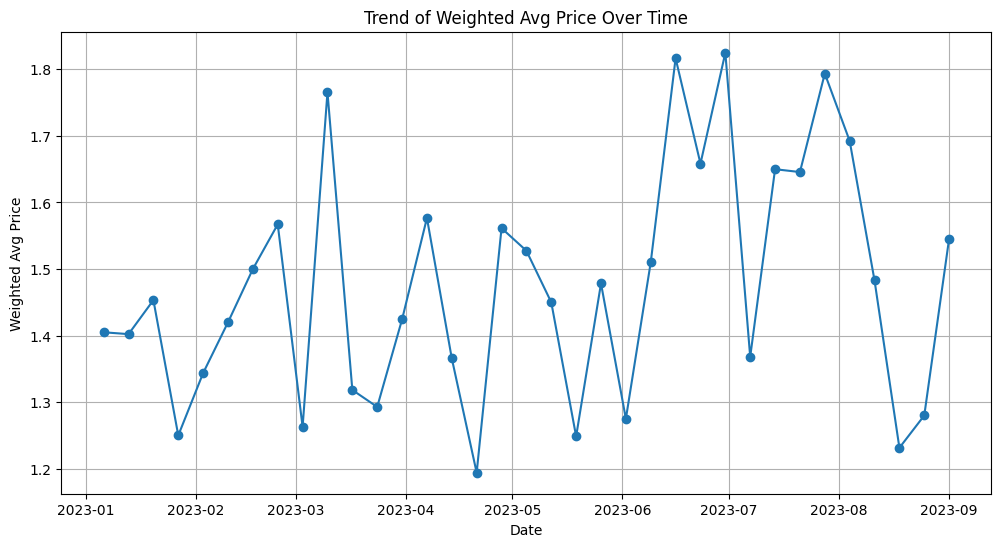

In [17]:
# 2. Time Series Analysis
# Trend of Weighted Avg Price over time
time_series_data = cleaned_data.groupby('Date')['Weighted Avg Price'].mean()
plt.figure(figsize=(12, 6))
plt.plot(time_series_data, marker='o')
plt.title("Trend of Weighted Avg Price Over Time")
plt.xlabel("Date")
plt.ylabel("Weighted Avg Price")
plt.grid()
plt.show()

**Insights:** The average price of avocados shows noticeable ups and downs over time, with the highest spikes in March and July 2023. This suggests that avocado prices might be influenced by seasons or shifts in demand and supply.

In [18]:
# 3. Regional Analysis
# Average Weighted Avg Price and Number of Stores per Region
regional_data = cleaned_data.groupby('Region').agg(
    Avg_Price=('Weighted Avg Price', 'mean'),
    Total_Stores=('Number of Stores', 'sum')
).sort_values(by='Avg_Price', ascending=False)

print("\nRegional Data Summary:")
print(regional_data)


Regional Data Summary:
                Avg_Price  Total_Stores
Region                                 
SOUTHEAST U.S.   1.555783         80870
NORTHEAST U.S.   1.510000         59040
MIDWEST U.S.     1.340704         43060


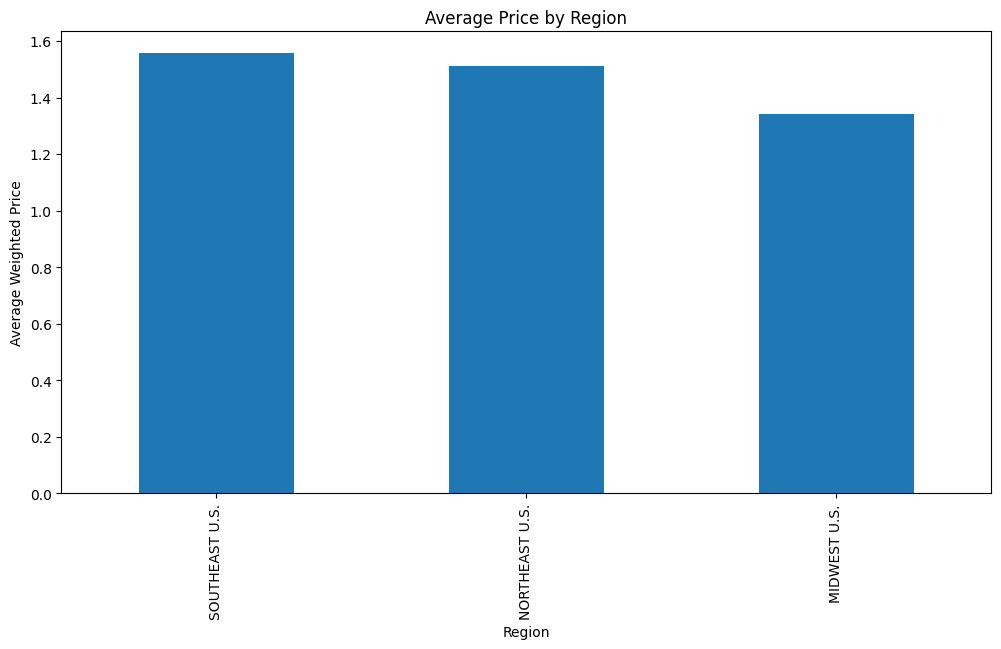

In [19]:
# Bar plot for average price per region
regional_data['Avg_Price'].plot(kind='bar', figsize=(12, 6), title="Average Price by Region")
plt.ylabel("Average Weighted Price")
plt.show()

**Insights:** Avocado prices are slightly higher in the Southeast U.S. compared to the Northeast and Midwest, suggesting regional factors like transportation costs or local demand may influence pricing.

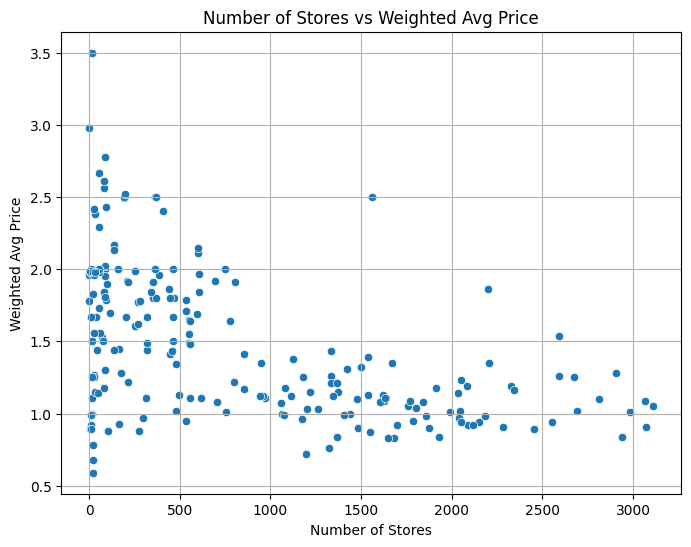

In [20]:
# 4. Correlation Analysis
# Scatter plot between Number of Stores and Weighted Avg Price
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Number of Stores', y='Weighted Avg Price', data=cleaned_data)
plt.title("Number of Stores vs Weighted Avg Price")
plt.xlabel("Number of Stores")
plt.ylabel("Weighted Avg Price")
plt.grid()
plt.show()

**Insights:** The graph shows that as the number of stores increases, the average price of avocados tends to decrease. This suggests that larger market coverage and competition among stores may drive prices lower.

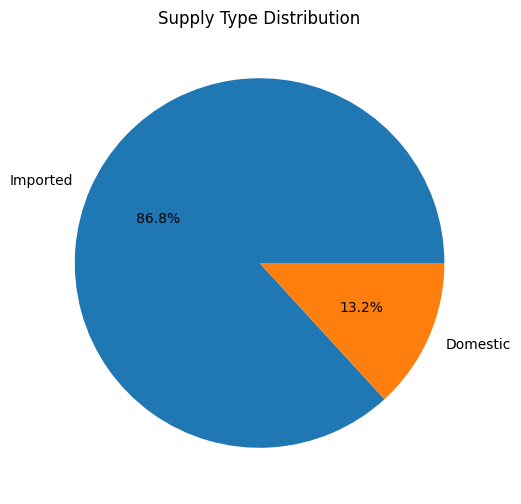

In [21]:
# 5. Supply Type Distribution
supply_type_distribution = cleaned_data['Supply Type'].value_counts(normalize=True)
plt.figure(figsize=(6, 6))
supply_type_distribution.plot(kind='pie', autopct='%1.1f%%', title="Supply Type Distribution")
plt.ylabel("")
plt.show()

**Insights:** The updated chart shows that 86.8% of avocado supplies are imported, while 13.2% are domestic. This reflects the industry reality, where the majority of avocados in the U.S. are sourced internationally.

### **Data Preparation for Optimization**

In [22]:
# Summarize data by Region and Supply Type
supply_summary = cleaned_data.groupby(['Region', 'Supply Type']).agg(
    Avg_Price=('Weighted Avg Price', 'mean'),
    Total_Stores=('Number of Stores', 'sum')
).reset_index()

supply_summary

,Region,Supply Type,Avg_Price,Total_Stores
0,MIDWEST U.S.,Domestic,1.123636,8831
1,MIDWEST U.S.,Imported,1.380500,34229
2,NORTHEAST U.S.,Domestic,1.560000,4668
3,NORTHEAST U.S.,Imported,1.503750,54372
4,SOUTHEAST U.S.,Domestic,1.611818,10331
5,SOUTHEAST U.S.,Imported,1.547222,70539


## **OPTIMIZATION**

In [23]:
# Summarize data by Region and Supply Type
supply_summary = cleaned_data.groupby(['Region', 'Supply Type']).agg(
    Avg_Price=('Weighted Avg Price', 'mean'),
    Total_Demand=('Number of Stores', 'sum')  # Use Number of Stores as demand proxy
).reset_index()

# Pivot the summary to create columns for Domestic and Imported costs
supply_pivot = supply_summary.pivot(index='Region', columns='Supply Type', values='Avg_Price').reset_index()
supply_pivot['Demand'] = supply_summary.groupby('Region')['Total_Demand'].sum().values

# Fill any missing values with a high cost to discourage selection
supply_pivot = supply_pivot.fillna(1000)


In [24]:
# Prepare the data (ensure that 'supply_pivot' reflects updated proportions and costs)
regions = supply_pivot['Region'].tolist()
domestic_costs = supply_pivot['Domestic'].tolist()
imported_costs = supply_pivot['Imported'].tolist()
demands = supply_pivot['Demand'].tolist()

# Initialize the optimization problem
model = LpProblem("Avocado_Supply_Optimization", LpMinimize)

# Decision variables for each region and supply type
x_domestic = {r: LpVariable(f"x_domestic_{r}", 0, 1) for r in regions}
x_imported = {r: LpVariable(f"x_imported_{r}", 0, 1) for r in regions}

# Objective: Minimize total cost
model += lpSum(
    x_domestic[r] * domestic_costs[i] +
    x_imported[r] * imported_costs[i]
    for i, r in enumerate(regions)
)

# Constraints
for i, r in enumerate(regions):
    # Demand constraint: Domestic + Imported = 1
    model += x_domestic[r] + x_imported[r] == 1, f"Demand_Constraint_{r}"

    # Supply proportion constraints
    model += x_domestic[r] <= 0.1, f"Domestic_Limit_{r}"  # At most 10% domestic
    model += x_imported[r] >= 0.9, f"Imported_Limit_{r}"  # At least 90% imported

# Solve the problem
model.solve()

# Output results
results = []
for r in regions:
    results.append({
        'Region': r,
        'Domestic Proportion': x_domestic[r].varValue,
        'Imported Proportion': x_imported[r].varValue
    })


# Create a DataFrame for the results
results_df = pd.DataFrame(results)

print(results_df)

           Region  Domestic Proportion  Imported Proportion
0    MIDWEST U.S.                  0.1                  0.9
1  NORTHEAST U.S.                  0.0                  1.0
2  SOUTHEAST U.S.                  0.0                  1.0


### **Insights:**
- **Midwest U.S.:** Allocated 10% domestic and 90% imported supply, showing moderate competitiveness for domestic avocados in this region.

- **Northeast & Southeast U.S.:** Both rely entirely on imported supply (100%), likely due to cost advantages or logistical challenges for domestic distribution.

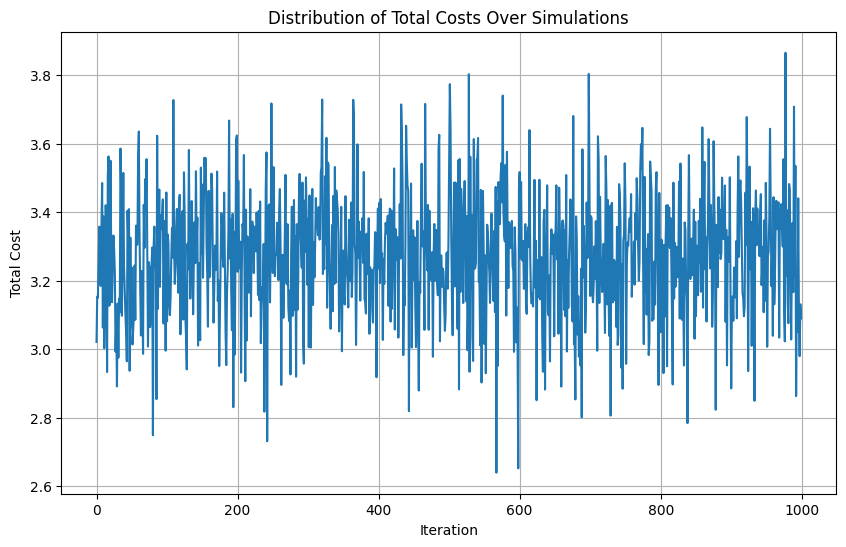

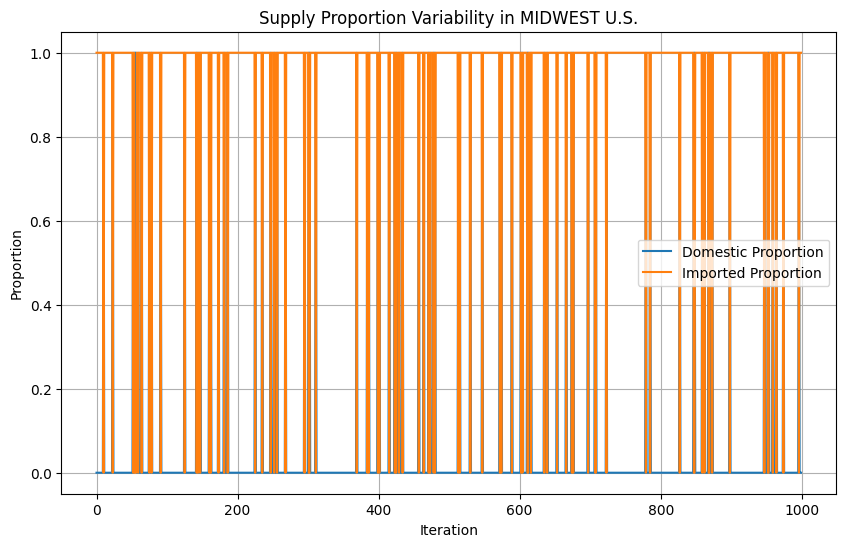

Simulation results saved to 'Simulation_Results.xlsx'


In [25]:

# Assume `domestic_costs` and `imported_costs` are the baseline costs for each region
# Assume `regions` contains the list of region names
# Placeholder values for demonstration purposes (replace with actual data)
regions = ['MIDWEST U.S.', 'NORTHEAST U.S.', 'SOUTHEAST U.S.']
domestic_costs = [1.2, 1.3, 1.4]  # Avg domestic costs for each region
imported_costs = [1.0, 1.1, 1.2]  # Avg imported costs for each region

# Simulate costs and demand over 1000 iterations
n_simulations = 1000
domestic_costs_simulated = np.random.normal(
    loc=domestic_costs, scale=0.1 * np.array(domestic_costs), size=(n_simulations, len(regions))
)
imported_costs_simulated = np.random.normal(
    loc=imported_costs, scale=0.1 * np.array(imported_costs), size=(n_simulations, len(regions))
)

# Decision variables for optimization model
x_domestic = {r: LpVariable(f"x_domestic_{r}", 0, 1) for r in regions}
x_imported = {r: LpVariable(f"x_imported_{r}", 0, 1) for r in regions}

# Store results for analysis
simulation_results = []
for i in range(n_simulations):
    # Adjust the costs for this iteration
    adjusted_domestic_costs = domestic_costs_simulated[i]
    adjusted_imported_costs = imported_costs_simulated[i]

    # Create and solve the optimization model
    model = LpProblem("Avocado_Supply_Optimization_Simulation", LpMinimize)
    model += lpSum(
        x_domestic[r] * adjusted_domestic_costs[j] +
        x_imported[r] * adjusted_imported_costs[j]
        for j, r in enumerate(regions)
    )

    for r in regions:
        model += x_domestic[r] + x_imported[r] == 1, f"Demand_Constraint_{r}"

    model.solve()

    # Store total cost and supply proportions for this iteration
    total_cost = value(model.objective)
    proportions = {r: (x_domestic[r].varValue, x_imported[r].varValue) for r in regions}
    simulation_results.append({'Iteration': i, 'Total Cost': total_cost, 'Proportions': proportions})

# Flatten simulation results for visualization
flat_results = []
for result in simulation_results:
    for region, props in result['Proportions'].items():
        flat_results.append({
            'Iteration': result['Iteration'],
            'Region': region,
            'Domestic Proportion': props[0],
            'Imported Proportion': props[1],
            'Total Cost': result['Total Cost']
        })

# Create a DataFrame for analysis
simulation_df = pd.DataFrame(flat_results)

# Visualization: Distribution of Total Costs Over Simulations
plt.figure(figsize=(10, 6))
simulation_df.groupby('Iteration')['Total Cost'].mean().plot(kind='line')
plt.title('Distribution of Total Costs Over Simulations')
plt.xlabel('Iteration')
plt.ylabel('Total Cost')
plt.grid()
plt.show()

# Visualization: Supply Proportion Variability for a Specific Region
region_to_plot = 'MIDWEST U.S.'  # Change to the region you want to visualize
region_data = simulation_df[simulation_df['Region'] == region_to_plot]

plt.figure(figsize=(10, 6))
plt.plot(region_data['Iteration'], region_data['Domestic Proportion'], label='Domestic Proportion')
plt.plot(region_data['Iteration'], region_data['Imported Proportion'], label='Imported Proportion')
plt.title(f'Supply Proportion Variability in {region_to_plot}')
plt.xlabel('Iteration')
plt.ylabel('Proportion')
plt.legend()
plt.grid()
plt.show()

# Save simulation results to a file for further analysis
simulation_df.to_excel("Simulation_Results.xlsx", index=False)
print("Simulation results saved to 'Simulation_Results.xlsx'")


**Overall Observations:**
The model clearly shows a strong preference for imported supply because it is consistently cheaper than domestic options, even when costs fluctuate. While the total cost varies slightly due to changing conditions, the supply proportions (imported vs. domestic) remain largely unaffected. Domestic supply plays a minimal role and only becomes viable in rare cases when its cost significantly drops.

### **Strategies which can be implimented:**
- **Boost Domestic Supply:** Focus domestic production in the Midwest, where it’s partially competitive. Use branding like “local” for premium markets.

- **Optimize Imports:** Strengthen import supply chains in the Northeast and Southeast through efficient transportation and partnerships.

- **Risk Mitigation:** Diversify supply sources and monitor geopolitical risks impacting imports.

- **Regular Updates:** Reevaluate costs and supply proportions periodically to adjust to market changes.